In [ ]:
pip install kats

In [5]:
#pip install prophet

In [1]:
# import kats
# Arima
# Prophet
# Neural Prosphet

ModuleNotFoundError: No module named 'kats'

In [6]:
import pandas as pd
import numpy as np
from prophet import Prophet

#import matplotlib.pyplot as plt

## Lectura de los datos

In [7]:
df = pd.read_csv("flightsCleaned.csv")
pd.set_option('display.max_columns', None)

# Añadimos el FlightNum como variable categórica
df['FLIGHT_NUMBER']=df['FLIGHT_NUMBER'].astype(object) 

# Configuramos DATE como variable de tipo datetime
df['DATE'] = pd.to_datetime(df['DATE'])

df.head()

,DATE,IATA_CODE,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,OTHER_DELAY,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,2015-01-01,AA,American Airlines Inc.,2336,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,West Palm Beach,FL,USA,26.68316,-80.09559
1,2015-01-01,US,US Airways Inc.,840,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,San Francisco,CA,USA,37.61900,-122.37484,Charlotte,NC,USA,35.21401,-80.94313
2,2015-01-01,AA,American Airlines Inc.,258,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Miami,FL,USA,25.79325,-80.29056
3,2015-01-01,DL,Delta Air Lines Inc.,806,SFO,MSP,25,20.0,-5.0,18.0,38.0,217.0,230.0,206.0,1589,604.0,6.0,602,610.0,8.0,0.0,0.0,0.0,0.0,0.0,8.0,San Francisco,CA,USA,37.61900,-122.37484,Minneapolis,MN,USA,44.88055,-93.21692
4,2015-01-01,US,US Airways Inc.,2013,LAX,CLT,30,44.0,14.0,13.0,57.0,273.0,249.0,228.0,2125,745.0,8.0,803,753.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Charlotte,NC,USA,35.21401,-80.94313


## Seleccionamos los datos

Queremos predecir los retrasos correspondientes con los 5 aeropuertos que experimentan mayor número de retrasos. En primer lugar debemos seleccionar dichos aeropuertos. Para ello calcularemos el número total de vuelos, el número total de vuelos retrasados y el % de vuelos retrasados para cada uno de los aeropuertos. Una vez hecho esto nos quedaremos con aquellos 5 que muestren un % de retrasos más elevado

In [8]:
airports = pd.DataFrame(df.groupby(df['ORIGIN_AIRPORT'])["FLIGHT_NUMBER"].count())
airports = airports.rename(columns={"FLIGHT_NUMBER":"TOTAL_FLIGHTS"})
airports["DELAYED_FLIGHTS"] =  df[df["ARRIVAL_DELAY"]>0].groupby(df['ORIGIN_AIRPORT'])["FLIGHT_NUMBER"].count()
airports["DELAY_PERCENTAGE"] = np.round(airports['DELAYED_FLIGHTS']/airports['TOTAL_FLIGHTS']*100,2)

# Ordenamos los aeropuertos de tal manera que los 5 con mayor % de retrasos aparezcan los primeros
airports = airports.sort_values('DELAY_PERCENTAGE',ascending=False)
airports

,TOTAL_FLIGHTS,DELAYED_FLIGHTS,DELAY_PERCENTAGE
ORIGIN_AIRPORT,,,
LAX,209631,85590,40.83
ORD,304120,121740,40.03
MIA,74230,29533,39.79
SFO,159585,60958,38.20
MCO,118538,43925,37.06
BOS,114895,41754,36.34
JFK,99918,35990,36.02
EWR,107849,38660,35.85
IAD,36643,12923,35.27


In [10]:
# Seleccionamos el top 5
aux = airports.reset_index(level=0, drop=False)

top_5_delay = aux.loc[0:4]
top_5_delay = top_5_delay['ORIGIN_AIRPORT']

In [11]:
# Filtramos nuestros datos para quedarnos únicamente con los correspondientes a dichos aeropuertos
df = df[df.ORIGIN_AIRPORT.isin(top_5_delay)]
df.head()

,DATE,IATA_CODE,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,OTHER_DELAY,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,2015-01-01,AA,American Airlines Inc.,2336,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,West Palm Beach,FL,USA,26.68316,-80.09559
1,2015-01-01,US,US Airways Inc.,840,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,San Francisco,CA,USA,37.61900,-122.37484,Charlotte,NC,USA,35.21401,-80.94313
2,2015-01-01,AA,American Airlines Inc.,258,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Miami,FL,USA,25.79325,-80.29056
3,2015-01-01,DL,Delta Air Lines Inc.,806,SFO,MSP,25,20.0,-5.0,18.0,38.0,217.0,230.0,206.0,1589,604.0,6.0,602,610.0,8.0,0.0,0.0,0.0,0.0,0.0,8.0,San Francisco,CA,USA,37.61900,-122.37484,Minneapolis,MN,USA,44.88055,-93.21692
4,2015-01-01,US,US Airways Inc.,2013,LAX,CLT,30,44.0,14.0,13.0,57.0,273.0,249.0,228.0,2125,745.0,8.0,803,753.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Charlotte,NC,USA,35.21401,-80.94313


In [ ]:
# Adjuntar mapa de los 5 aeropuertos

## Forecast

Prophet: https://facebook.github.io/prophet/docs/quick_start.html

Variable a predecir: **number of delays per airport and day**

### Aeropuerto 1

In [12]:
airport_1 = df[df['ORIGIN_AIRPORT']== top_5_delay[0]]
len(airport_1)

209631

In [19]:
airport_1.head()

,DATE,IATA_CODE,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,OTHER_DELAY,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,2015-01-01,AA,American Airlines Inc.,2336,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,West Palm Beach,FL,USA,26.68316,-80.09559
2,2015-01-01,AA,American Airlines Inc.,258,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Miami,FL,USA,25.79325,-80.29056
4,2015-01-01,US,US Airways Inc.,2013,LAX,CLT,30,44.0,14.0,13.0,57.0,273.0,249.0,228.0,2125,745.0,8.0,803,753.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Charlotte,NC,USA,35.21401,-80.94313
6,2015-01-01,DL,Delta Air Lines Inc.,1434,LAX,MSP,35,35.0,0.0,18.0,53.0,214.0,210.0,188.0,1535,601.0,4.0,609,605.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Minneapolis,MN,USA,44.88055,-93.21692
8,2015-01-01,AA,American Airlines Inc.,115,LAX,MIA,105,103.0,-2.0,14.0,117.0,286.0,276.0,255.0,2342,832.0,7.0,851,839.0,-12.0,0.0,0.0,0.0,0.0,0.0,0.0,Los Angeles,CA,USA,33.94254,-118.40807,Miami,FL,USA,25.79325,-80.29056


#### Data preparation

In [13]:
# Tenemos que agrupar los datos por día
airport_1_df = pd.DataFrame(airport_1.groupby(airport_1['DATE'])["FLIGHT_NUMBER"].count())
airport_1_df = airport_1_df.rename(columns={"FLIGHT_NUMBER":"TOTAL_FLIGHTS"})
airport_1_df["DELAYED_FLIGHTS"] =  airport_1[airport_1["ARRIVAL_DELAY"]>0].groupby(airport_1['DATE'])["FLIGHT_NUMBER"].count()
airport_1_df["DELAY_PERCENTAGE"] = np.round(airport_1_df['DELAYED_FLIGHTS']/airport_1_df['TOTAL_FLIGHTS']*100,2)

# Ordenamos los aeropuertos de tal manera que los 5 con mayor % de retrasos aparezcan los primeros
airport_1_df = airport_1_df.sort_values('DELAY_PERCENTAGE',ascending=False)
airport_1_df.describe()

,TOTAL_FLIGHTS,DELAYED_FLIGHTS,DELAY_PERCENTAGE
count,365.000000,365.000000,365.000000
mean,574.331507,234.493151,40.490795
std,45.841008,74.273500,11.575265
min,369.000000,62.000000,14.340000
25%,555.000000,184.000000,32.510000
50%,582.000000,227.000000,39.510000
75%,603.000000,283.000000,47.520000
max,645.000000,467.000000,76.560000


In [9]:
airport_1_df.head()

,TOTAL_FLIGHTS,DELAYED_FLIGHTS,DELAY_PERCENTAGE
DATE,,,
2015-01-04,610,467,76.56
2015-01-03,571,437,76.53
2015-03-13,603,437,72.47
2015-07-18,543,390,71.82
2015-02-05,552,395,71.56


In [ ]:
# Distribución de los retrasos del aeroupuerto

#### Modelling

In [20]:
data = airport_1_df.reset_index(level=0, drop=False)
data = data.loc[:,['DATE', 'DELAYED_FLIGHTS']] 

# Cambiamos el nombre a las columnas para que vaya a corde con el modelo
data.columns = ['ds','y']
data.head()

,ds,y
0,2015-01-04,467
1,2015-01-03,437
2,2015-03-13,437
3,2015-07-18,390
4,2015-02-05,395


In [21]:
print(len(data))

365


In [28]:
# Define the model
model = Prophet()

# Fit the model
model.fit(data)

11:24:38 - cmdstanpy - INFO - Chain [1] start processing
11:24:44 - cmdstanpy - INFO - Chain [1] done processing
11:24:44 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
11:24:44 - cmdstanpy - INFO - Chain [1] start processing
11:24:47 - cmdstanpy - INFO - Chain [1] done processing
11:24:47 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization! Command 'C:\Users\gfine\Anaconda3\lib\site-packages\prophet\stan_model\prophet_model.bin random seed=76854 data file=C:\Users\gfine\AppData\Local\Temp\tmp6vqs21sp\2hp9cf3d.json init=C:\Users\gfine\AppData\Local\Temp\tmp6vqs21sp\7cqpspox.json output file=C:\Users\gfine\AppData\Local\Temp\tmp6vqs21sp\prophet_model8ik79jzh\prophet_model-20221126112444.csv method=optimize algorithm=newton iter=10000' failed: 

In [25]:
#pip install fbprophet

In [26]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

ModuleNotFoundError: No module named 'fbprophet'

In [22]:
m = Prophet()
m.fit(data)

11:19:32 - cmdstanpy - INFO - Chain [1] start processing
11:19:38 - cmdstanpy - INFO - Chain [1] done processing
11:19:38 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
11:19:38 - cmdstanpy - INFO - Chain [1] start processing
11:19:39 - cmdstanpy - INFO - Chain [1] done processing
11:19:39 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization! Command 'C:\Users\gfine\Anaconda3\lib\site-packages\prophet\stan_model\prophet_model.bin random seed=87396 data file=C:\Users\gfine\AppData\Local\Temp\tmp6vqs21sp\7l5ws7jo.json init=C:\Users\gfine\AppData\Local\Temp\tmp6vqs21sp\i3sh2_7l.json output file=C:\Users\gfine\AppData\Local\Temp\tmp6vqs21sp\prophet_modelv3tmj5na\prophet_model-20221126111938.csv method=optimize algorithm=newton iter=10000' failed: 

In [36]:
# Data preparation
# ==============================================================================
airport_1['DATE'] = pd.to_datetime(airport_1['DATE'], format='%Y/%m/%d')

# airport_1
airport_1 = airport_1.set_index('DATE')
airport_1 = airport_1.rename(columns={'ARRIVAL_DELAY': 'y'})
airport_1 = airport_1.asfreq('MS')
airport_1 = airport_1.sort_index()
airport_1.head()

C:\Users\gfine\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: cannot reindex from a duplicate axis

Train dates : 2015-01-01 00:00:00 --- 2015-09-21 00:00:00  (n=153602)
Test dates  : 2015-09-21 00:00:00 --- 2015-12-31 00:00:00  (n=38401)


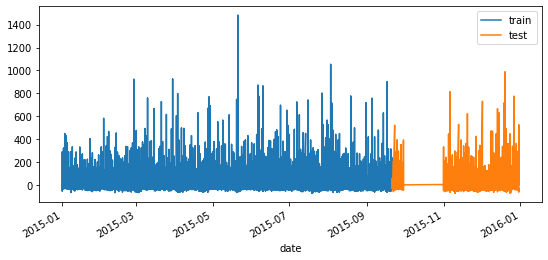

In [37]:
# 20% de los datos para test
steps = int(round(0.2*len(airport_1),0))

data_train = airport_1[:-steps]
data_test  = airport_1[-steps:]

print(f"Train dates : {data_train.DATE.min()} --- {data_train.DATE.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.DATE.min()} --- {data_test.DATE.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

#### Exploring the results